In [177]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn.feature_selection import RFE
import pickle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import optuna.visualization as vis
import time
import scipy.stats as st
from sklearn.model_selection import cross_val_score


In [179]:
df = pd.read_csv("../data/raw/winequality-white.csv", sep=';')
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [181]:
#droping columns that is not much related with target and highly related with other features
df.drop(['citric acid','density','pH'],axis=1,inplace=True)
#reducing skewness with log
df['residual sugar'] = np.log1p(df['residual sugar'])
df['free sulfur dioxide'] = np.log1p(df['free sulfur dioxide'])
df['alcohol'] = np.log1p(df['alcohol'])
df['chlorides'] = np.log1p(df['chlorides'])
df['volatile acidity'] = np.log1p(df['volatile acidity'])
df.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.0,0.239017,3.077312,0.044017,3.828641,170.0,0.45,2.282382,6
1,6.3,0.262364,0.955511,0.047837,2.708050,132.0,0.49,2.351375,6
2,8.1,0.246860,2.066863,0.048790,3.433987,97.0,0.44,2.406945,6
3,7.2,0.207014,2.251292,0.056380,3.871201,186.0,0.40,2.388763,6
4,7.2,0.207014,2.251292,0.056380,3.871201,186.0,0.40,2.388763,6


In [183]:
features = df.columns.drop('quality')
# Dictionary to store outlier indices per feature
outliers_dict = {}

# Loop through each feature and identify outliers using IQR
for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
    outliers_dict[col] = outliers
    print(f"{col}: {len(outliers)} outliers")

# Example: Print outlier indices for 'residual sugar'
print("\nOutlier indices for 'residual sugar':")
print(outliers_dict['residual sugar'][:10])  # show first 10 indices
# Combine all outlier indices from all features
all_outliers = set()
for idx_list in outliers_dict.values():
    all_outliers.update(idx_list)

#Drop outlier rows from the DataFrame
df_cleaned = df.drop(index=all_outliers).reset_index(drop=True)

print(f"\nOriginal shape: {df.shape}")
print(f"New shape after outlier removal: {df_cleaned.shape}")

fixed acidity: 119 outliers
volatile acidity: 156 outliers
residual sugar: 0 outliers
chlorides: 212 outliers
free sulfur dioxide: 109 outliers
total sulfur dioxide: 19 outliers
sulphates: 124 outliers
alcohol: 0 outliers

Outlier indices for 'residual sugar':
Index([], dtype='int64')

Original shape: (4898, 9)
New shape after outlier removal: (4226, 9)


In [185]:
#Train test Split
features = df_cleaned.drop(columns = ["quality"])
target = df_cleaned["quality"]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [187]:
#using Knn Regressor

knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train, y_train)
#model evaluation
knn.score(X_test, y_test)

0.07750782347011853

# KNN Regressor

In [229]:
#Create an instance of the class MinMaxScaler normalizer
normalizer = MinMaxScaler()
#applying .fit()class method only to the train set to find the max and min
normalizer.fit(X_train)
#apply the transformation to training nad testing data
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)
#converting X_train_norm to pandas Dataframe
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index=X_train.index )
##converting X_test_norm to pandas Dataframe
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns, index=X_test.index)
#KNN Regressor - modeling
knn = KNeighborsRegressor(n_neighbors=9)
#Training KNN to our normalized data
knn.fit(X_train_norm, y_train)

# Predict on test set
y_pred = knn.predict(X_test_norm)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print metrics
print(f"The R² of the model on the TEST set is: {r2: .2f}")
print(f"Mean Absolute Error (MAE): {mae: .2f}")
print(f"Mean Squared Error (MSE): {mse: .2f}")
print(f"Root Mean Squared Error (RMSE): {rmse: .2f}")

The R² of the model on the TEST set is:  0.31
Mean Absolute Error (MAE):  0.53
Mean Squared Error (MSE):  0.48
Root Mean Squared Error (RMSE):  0.69


In [192]:
#scaling with standard scaler
std_scaler = StandardScaler()

std_scaler.fit(X_train)
X_train_std = std_scaler.transform(X_train)
X_test_std  = std_scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns, index=X_train.index )
X_train_std.head()

X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns, index=X_test.index)
X_test_std.head()
#KNN Regressor - modeling
knn = KNeighborsRegressor(n_neighbors=9)
#Training KNN to our normalized data
knn.fit(X_train_std, y_train)
#Evaluate model's performance
print(f"The R2 of the model on the TEST set is: {knn.score(X_test_std, y_test): .2f}")

The R2 of the model on the TEST set is:  0.30


# Linear Regression

In [195]:

model = LinearRegression()
rfe = RFE(model, n_features_to_select=8)  # Keep top 8 features
rfe.fit(X_train_norm, y_train)

# Get selected columns
selected_columns = features.columns[rfe.support_]
print("Selected features:", selected_columns)
lin_reg = LinearRegression()
lin_reg2 = LinearRegression()
lin_reg.fit(X_train_norm, y_train) # Determines the b0 and b1's values
lin_reg2.fit(X_train_std, y_train)
y_pred_test = lin_reg.predict(X_test_norm)
#lin_reg.score(X_test_norm, y_test)
print(f"MAE {mean_absolute_error(y_pred_test, y_test): .2f}") # mean(abs(error)) = mean(abs(y_test - y_pred_test))
print(f"MSE {mean_squared_error(y_pred_test, y_test): .2f}") # mean(error**2) = mean((y_test - y_pred_test)**2)
print(f"RMSE, {root_mean_squared_error(y_pred_test, y_test): .2f}") # sqrt( mean( (y_test - y_pred_test)^2 ) ) # b0, b1, b2...
print(f"R2 score, {lin_reg.score(X_test_norm, y_test): .2f}") # r2_score

Selected features: Index(['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol'],
      dtype='object')
MAE  0.57
MSE  0.51
RMSE,  0.72
R2 score,  0.26


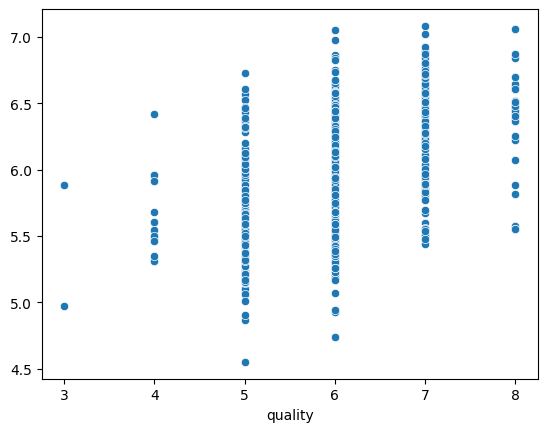

In [197]:
sns.scatterplot(x=y_test, y=y_pred_test); # y_pred_test = y_test;  y_pred_test = 0 + y_test; y_pred_test = 0 + 1 * y_test

In [199]:
y_pred_test2 = lin_reg2.predict(X_test_std)

#lin_reg.score(X_test_norm_df, y_test)

#print(f"MAE {mean_absolute_error(y_pred_test, y_test): .2f}") # mean(abs(error)) = mean(abs(y_test - y_pred_test))
#print(f"MSE {mean_squared_error(y_pred_test, y_test): .2f}") # mean(error**2) = mean((y_test - y_pred_test)**2)
#print(f"RMSE, {root_mean_squared_error(y_pred_test, y_test): .2f}") # sqrt( mean( (y_test - y_pred_test)^2 ) ) # b0, b1, b2...
#print(f"R2 score, {lin_reg.score(X_test_std, y_test): .2f}") # r2_score

# Decision Tree Regressor

In [202]:
#initialize decision tree instance
tree = DecisionTreeRegressor(max_depth=4)
#train a Decision Tree
tree.fit(X_train_norm, y_train)
y_pred_test_dt = tree.predict(X_test_norm)
print(f"MAE, {mean_absolute_error(y_pred_test_dt, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_dt, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_dt, y_test): .2f}")
print(f"R2 score, {tree.score(X_test_norm, y_test): .2f}")

MAE,  0.57
MSE,  0.51
RMSE,  0.71
R2 score,  0.27


In [204]:
tree_importance = {feature : importance for feature, importance in zip(X_train_norm.columns, tree.feature_importances_)}
tree_importance

{'fixed acidity': np.float64(0.028635658028058494),
 'volatile acidity': np.float64(0.17896096813687792),
 'residual sugar': np.float64(0.018050801272175048),
 'chlorides': np.float64(0.04004026367168743),
 'free sulfur dioxide': np.float64(0.05790708814224463),
 'total sulfur dioxide': np.float64(0.0),
 'sulphates': np.float64(0.0),
 'alcohol': np.float64(0.6764052207489565)}

In [206]:
from sklearn.tree import export_text

tree_viz = export_text(tree, feature_names=list(X_train_norm.columns))
print(tree_viz)

|--- alcohol <= 0.48
|   |--- volatile acidity <= 0.41
|   |   |--- alcohol <= 0.16
|   |   |   |--- chlorides <= 0.63
|   |   |   |   |--- value: [5.85]
|   |   |   |--- chlorides >  0.63
|   |   |   |   |--- value: [6.71]
|   |   |--- alcohol >  0.16
|   |   |   |--- alcohol <= 0.35
|   |   |   |   |--- value: [5.80]
|   |   |   |--- alcohol >  0.35
|   |   |   |   |--- value: [6.06]
|   |--- volatile acidity >  0.41
|   |   |--- alcohol <= 0.30
|   |   |   |--- volatile acidity <= 0.57
|   |   |   |   |--- value: [5.46]
|   |   |   |--- volatile acidity >  0.57
|   |   |   |   |--- value: [5.24]
|   |   |--- alcohol >  0.30
|   |   |   |--- free sulfur dioxide <= 0.40
|   |   |   |   |--- value: [5.35]
|   |   |   |--- free sulfur dioxide >  0.40
|   |   |   |   |--- value: [5.78]
|--- alcohol >  0.48
|   |--- alcohol <= 0.65
|   |   |--- free sulfur dioxide <= 0.13
|   |   |   |--- fixed acidity <= 0.39
|   |   |   |   |--- value: [6.20]
|   |   |   |--- fixed acidity >  0.39
|   |

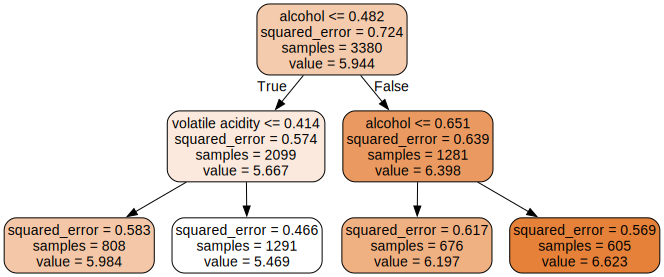

In [208]:


tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X_train_norm, y_train)


dot_data = export_graphviz(tree, out_file="tree.dot", filled=True, rounded=True, feature_names=X_train_norm.columns)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

# Random Forest Regressor

In [212]:
#initialize a random Forest
forest = RandomForestRegressor(n_estimators=200,
                             max_depth=30)
#Training the model
forest.fit(X_train_norm, y_train)
#Evaluate the model
y_pred_test_rf = forest.predict(X_test_norm)

print(f"MAE, {mean_absolute_error(y_pred_test_rf, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_rf, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_rf, y_test): .2f}")
print(f"R2 score, {forest.score(X_test_norm, y_test): .2f}")

MAE,  0.43
MSE,  0.36
RMSE,  0.60
R2 score,  0.48


# Ada Boost Regressor

In [215]:
#Initialize a AdaBoost model
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)
#Training the model
ada_reg.fit(X_train_norm, y_train)
y_pred_test_ada = ada_reg.predict(X_test_norm)
#Evaluate the model
print(f"MAE, {mean_absolute_error(y_pred_test_ada, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_ada, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_ada, y_test): .2f}")
print(f"R2 score, {ada_reg.score(X_test_norm, y_test): .2f}")

MAE,  0.33
MSE,  0.39
RMSE,  0.62
R2 score,  0.44


# Gradient Boosting Regressor

In [217]:
#Initialize GradientBoosting model
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)
gb_reg.fit(X_train_norm, y_train)
#Evaluate the model
y_pred_test_gb = gb_reg.predict(X_test_norm)

print(f"MAE, {mean_absolute_error(y_pred_test_gb, y_test): .2f}")
print(f"MSE, {mean_squared_error(y_pred_test_gb, y_test): .2f}")
print(f"RMSE, {root_mean_squared_error(y_pred_test_gb, y_test): .2f}")
print(f"R2 score, {gb_reg.score(X_test_norm, y_test): .2f}")

MAE,  0.45
MSE,  0.53
RMSE,  0.73
R2 score,  0.23


# Hyperparameter tuning

In [220]:

# Objective function for Bayesian search
def objective(trial, confidence_level, folds):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 10, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 4, 16)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 250, 1000)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Initialize RandomForestRegressor
    rf = RandomForestRegressor(
        random_state=123,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_leaf_nodes=max_leaf_nodes,
        max_features=max_features,
        n_jobs=-1
    )

    # Cross-validation
    scores = cross_val_score(rf, X_train_norm, y_train, cv=folds, scoring='r2')
    mean_score = np.mean(scores)
    sem = np.std(scores, ddof=1) / np.sqrt(folds)

    # Confidence interval
    tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
    lower_bound = mean_score - (tc * sem)
    upper_bound = mean_score + (tc * sem)

    # Store confidence interval in trial
    trial.set_user_attr("CV_score_summary", [
        round(lower_bound, 4),
        round(mean_score, 4),
        round(upper_bound, 4)
    ])

    return mean_score
confidence_level = 0.95
folds = 10

start_time = time.time()
study = optuna.create_study(direction="maximize")  # Maximize R²
study.optimize(lambda trial: objective(trial, confidence_level, folds), n_trials=45)
end_time = time.time()

# Print results
print("\n")
print(f"Time taken: {end_time - start_time: .4f} seconds")
print("\nBest hyperparameters found:", study.best_params)
print(f" Best R² found: {study.best_value: .4f}")

# Extract best trial confidence interval
results = sorted([
    (
        index,
        trial.user_attrs['CV_score_summary'][0],
        trial.user_attrs['CV_score_summary'][1],
        trial.user_attrs['CV_score_summary'][2]
    )
    for index, trial in enumerate(study.trials)
], key=lambda x: x[2], reverse=True)

print(f" R² confidence interval of best trial: {results[0][1:]}")

[I 2025-07-31 21:40:43,383] A new study created in memory with name: no-name-3a9fec4a-1aae-4533-8fe2-734ee9a295e5
[I 2025-07-31 21:40:44,766] Trial 0 finished with value: 0.4816933404130731 and parameters: {'n_estimators': 62, 'max_depth': 27, 'min_samples_split': 7, 'max_leaf_nodes': 952, 'max_features': 'log2'}. Best is trial 0 with value: 0.4816933404130731.
[I 2025-07-31 21:40:49,863] Trial 1 finished with value: 0.4749210695850813 and parameters: {'n_estimators': 256, 'max_depth': 33, 'min_samples_split': 6, 'max_leaf_nodes': 365, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4816933404130731.
[I 2025-07-31 21:40:51,308] Trial 2 finished with value: 0.45600280086100814 and parameters: {'n_estimators': 51, 'max_depth': 26, 'min_samples_split': 13, 'max_leaf_nodes': 927, 'max_features': 'log2'}. Best is trial 0 with value: 0.4816933404130731.
[I 2025-07-31 21:40:53,415] Trial 3 finished with value: 0.4992751749179522 and parameters: {'n_estimators': 87, 'max_depth': 33, 'mi



Time taken:  163.7629 seconds

Best hyperparameters found: {'n_estimators': 273, 'max_depth': 50, 'min_samples_split': 4, 'max_leaf_nodes': 942, 'max_features': 'sqrt'}
 Best R² found:  0.5026
 R² confidence interval of best trial: (np.float64(0.4783), np.float64(0.5026), np.float64(0.5268))


# Grid Search

In [221]:


# Hyperparameter grid
parameter_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 30],
    "min_samples_split": [2, 10],
    "max_features": ["sqrt", "log2"]
}

# Model
rf = RandomForestRegressor(random_state=123)

# GridSearchCV setup
confidence_level = 0.95
folds = 10
gs = GridSearchCV(rf, param_grid=parameter_grid, cv=folds, verbose=1, scoring='r2', n_jobs=-1)

# Fit model
start_time = time.time()
gs.fit(X_train_norm, y_train)
end_time = time.time()

# Results
print(f"\nTime taken: {end_time - start_time:.2f} seconds")
print("Best hyperparameters:", gs.best_params_)
print(f"Cross-validated R2 score: {gs.best_score_:.4f}")

# Confidence interval
results_df = pd.DataFrame(gs.cv_results_).sort_values(by="mean_test_score", ascending=False)
mean_score = results_df.iloc[0]["mean_test_score"]
std_score = results_df.iloc[0]["std_test_score"]
sem = std_score / np.sqrt(folds)
tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
lower_bound = mean_score - tc * sem
upper_bound = mean_score + tc * sem

print(f"95% Confidence Interval for R2: ({lower_bound:.4f}, {mean_score:.4f}, {upper_bound:.4f})")

# Final model evaluation
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test_norm)

print("\n Test Evaluation:")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE : {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R2  : {r2_score(y_test, y_pred):.4f}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits

Time taken: 23.78 seconds
Best hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Cross-validated R2 score: 0.5128
95% Confidence Interval for R2: (0.4886, 0.5128, 0.5370)

 Test Evaluation:
MAE : 0.4182
MSE : 0.3411
RMSE: 0.5841
R2  : 0.5070


# Random Search

In [222]:
# Define hyperparameter grid
parameter_grid = {
    "max_leaf_nodes": [int(x) for x in np.linspace(start=50, stop=500, num=5)],
    "max_depth": [int(x) for x in np.linspace(5, 30, num=5)],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [100, 150, 200],
    "max_features": ["sqrt", "log2"]
}

# Model instance
rf = RandomForestRegressor(random_state=123)

# Setup RandomizedSearchCV
confidence_level = 0.95
folds = 10
n_iter = 20

rs = RandomizedSearchCV(
    rf,
    param_distributions=parameter_grid,
    n_iter=n_iter,
    cv=folds,
    verbose=10,
    random_state=123,
    n_jobs=-1,
    scoring="r2"
)

# Fit the model
start_time = time.time()
rs.fit(X_train_norm, y_train)
end_time = time.time()

# Display results
print("\n")
print(f"Time taken to find the best combination of hyperparameters: {end_time - start_time:.4f} seconds\n")
print("Best hyperparameters:", rs.best_params_)
print(f"Best cross-validated R2: {rs.best_score_:.4f}")

# Confidence interval calculation
results_rs_df = pd.DataFrame(rs.cv_results_).sort_values(by="mean_test_score", ascending=False)
rs_mean_score = results_rs_df.iloc[0]["mean_test_score"]
rs_std_score = results_rs_df.iloc[0]["std_test_score"]
rs_sem = rs_std_score / np.sqrt(folds)

rs_tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
rs_lower_bound = rs_mean_score - rs_tc * rs_sem
rs_upper_bound = rs_mean_score + rs_tc * rs_sem

print(f"R2 confidence interval for the best combination: ({rs_lower_bound:.4f}, {rs_mean_score:.4f}, {rs_upper_bound:.4f})")

# Evaluate on test set
best_model = rs.best_estimator_
y_pred_test = best_model.predict(X_test_norm)

print("\n Test Set Evaluation:")
print(f"Test MAE : {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"Test MSE : {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"Test R2  : {r2_score(y_test, y_pred_test):.4f}")

Fitting 10 folds for each of 20 candidates, totalling 200 fits


Time taken to find the best combination of hyperparameters: 14.2514 seconds

Best hyperparameters: {'n_estimators': 150, 'min_samples_split': 5, 'max_leaf_nodes': 500, 'max_features': 'log2', 'max_depth': 30}
Best cross-validated R2: 0.4936
R2 confidence interval for the best combination: (0.4723, 0.4936, 0.5149)

 Test Set Evaluation:
Test MAE : 0.4460
Test MSE : 0.3612
Test RMSE: 0.6010
Test R2  : 0.4781


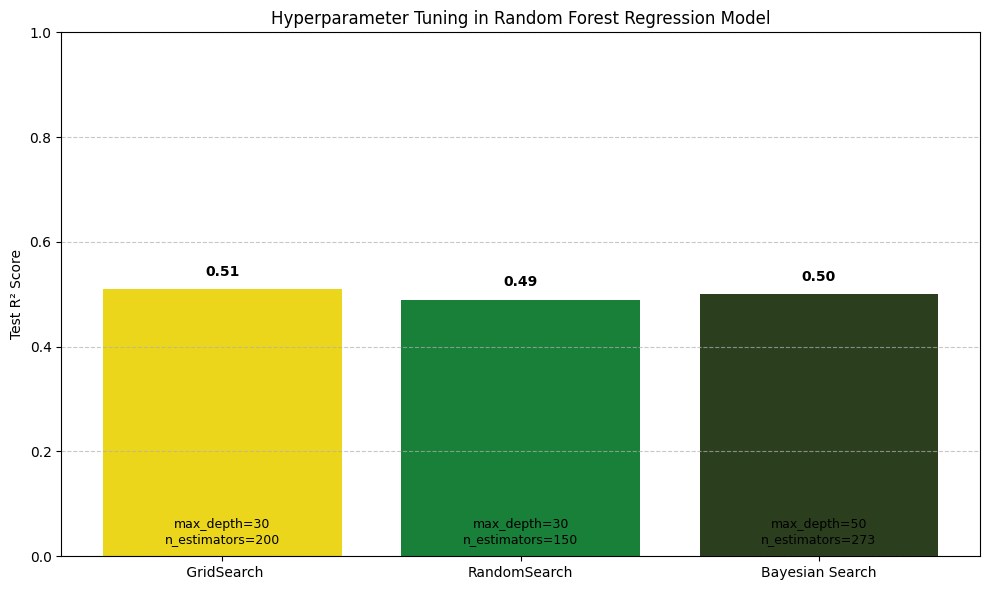

In [248]:
import matplotlib.pyplot as plt

# Model info
models = [" GridSearch", "RandomSearch", "Bayesian Search"]
test_scores = [0.51, 0.49, 0.50]

# Add corresponding best hyperparameters as strings
param_labels = [
    "max_depth=30\nn_estimators=200",
    "max_depth=30\nn_estimators=150",
    "max_depth=50\nn_estimators=273"
]

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, test_scores, color=["#EBD61C", "#188038", "#2B3F1F"])
plt.ylabel("Test R² Score")
plt.title("Hyperparameter Tuning in Random Forest Regression Model")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle='--', alpha=0.7)

# Add parameter annotations above or inside bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{test_scores[i]:.2f}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    
    plt.text(bar.get_x() + bar.get_width() / 2, 0.02, param_labels[i], 
             ha='center', va='bottom', fontsize=9, color='black', rotation=0)

plt.tight_layout()
plt.savefig("model_comparison_with_params.png")
plt.show()
